In [1]:
from leagues.models import Competition,Season
from base_app.helpers import best_fuzzy_match
from metrics.helpers.infered_carry import infer_carries_with_confidence 
from metrics.phases.attack import AttackPhase
from games.models import Game
from base_app.models import ConfigItems,OptaEvents,OptaQualifier

from datetime import datetime
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [2]:
isl_seasons = Season.objects.filter(competition__id=5).order_by('-name')[:4]
base_location = ConfigItems.objects.get(key = "PREPARED_EVENT_PATH").value

In [3]:
valid_files = {}
for sns in isl_seasons:
    
    sns_path = f'{base_location}/{sns.competition.confederation}/{sns.competition.country.replace(" ","_")}/{sns.competition.competition_name.replace(" ","_")}/{sns.name.replace("/","-").replace(" ","_")}'
    if os.path.exists(sns_path):
        for a,b,files in os.walk(sns_path):
            valid_files[sns.name.replace("/","-").replace(" ","_")] = [os.path.join(a,f) for f in files]

    

In [4]:
example = valid_files['2024-2025'][0]
head,tail = os.path.split(example)

In [5]:
results = {
    'field_tilt' : [],
    'attacking_3rd_entry_team' : [],
    'attacking_3rd_entry_player' : [],
    'total_xt' : [],
    'progressive_zone' : [],
    'vericality' : [],
    'offensive_width' : [],
    'centrality' : [],
    'shooting_team' : [],
    'shooting_player' : []
}

In [6]:
def prepare_df_for_merge(df,g_id) :
    df = df.reset_index()
    df['game_id'] = g_id
    return df 
    
for file in valid_files['2024-2025']:
    obj = AttackPhase(file)
    # 'field_tilt'
    results['field_tilt'].append(obj.get_field_tilt_values())
    
    # 'attacking_3rd_entry_team'
    third_entry_team,third_entry_player = obj.get_final_third_entires()
    results['attacking_3rd_entry_team'].append(prepare_df_for_merge(third_entry_team,obj.game_id))
    
    # 'attacking_3rd_entry_player'
    results['attacking_3rd_entry_player'].append(prepare_df_for_merge(third_entry_player,obj.game_id))
    
    # 'total_xt'
    total_xt = obj.get_pass_total_xt()
    results['total_xt'].append(prepare_df_for_merge(total_xt,obj.game_id))
    
    # 'progressive_zone'
    prog = obj.get_progression_df()
    prog_zones = obj.get_routes_covering_threshold(prog)
    results['progressive_zone'].append(prepare_df_for_merge(prog_zones,obj.game_id))
    
    # 'vericality'
    vert = obj.get_verticality_with_actions()
    results['vericality'].append(prepare_df_for_merge(vert,obj.game_id))
    
    # 'offensive_width'
    off_width = obj.get_offensive_width()
    results['offensive_width'].append(prepare_df_for_merge(off_width,obj.game_id))
    
    # 'centrality'
    cent = obj.get_centrality_data()
    results['centrality'].append(prepare_df_for_merge(cent,obj.game_id))
    
    # 'shooting_team'
    team,player = obj.aggregate_shots_team_and_player()
    results['shooting_team'].append(prepare_df_for_merge(team,obj.game_id))
    
    # 'shooting_player'
    results['shooting_player'].append(prepare_df_for_merge(player,obj.game_id))
    

In [7]:
[f"{k} -> {len(v)}" for k,v in results.items()]

['field_tilt -> 163',
 'attacking_3rd_entry_team -> 163',
 'attacking_3rd_entry_player -> 163',
 'total_xt -> 163',
 'progressive_zone -> 163',
 'vericality -> 163',
 'offensive_width -> 163',
 'centrality -> 163',
 'shooting_team -> 163',
 'shooting_player -> 163']

In [8]:
head.replace('PreparedEvents','Aggregated_Files')

'D:/Aggregated_Files/AFC/India/Indian_Super_League/2024-2025'

In [9]:
os.makedirs(f"{head.replace('PreparedEvents','Aggregated_Files')}/Icons",exist_ok=True)

In [10]:
# f
for k,v in results.items() :
    df = pd.concat(v)
    path = f"{head.replace('PreparedEvents','Aggregated_Files')}/Attack"
    os.makedirs(path,exist_ok=True)
    df.to_csv(f"{path}/{k}.csv",index=False)

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

def set_plot_style():
    # Base seaborn theme
    sns.set_theme(
        style="whitegrid",
        context="talk",
        font_scale=1.0
    )

    # Default color cycle
    plt.rcParams["axes.prop_cycle"] = plt.cycler(
    color=[
        "#0F766E",
        "#115E59",
        "#134E4A",
        "#166534",
        "#15803D",
        "#16A34A",
        "#22C55E",
        "#4ADE80",
        "#86EFAC",
        "#D9F99D",
        "#FEF08A",
        "#FACC15",
        ]
    )


    # Global rcParams
    plt.rcParams.update({
        # ---- Backgrounds ----
        "figure.facecolor": "#323232",
        "axes.facecolor": "#323232",
        "savefig.facecolor": "#323232",

        # ---- Grid ----
        "axes.grid": True,
        "grid.color": "#555555",
        "grid.linestyle": "--",
        "grid.alpha": 0.5,

        # ---- Spines ----
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.spines.left": True,
        "axes.spines.bottom": True,
        "axes.edgecolor": "#A0A0A0",

        # ---- Text ----
        "text.color": "#EAEAEA",
        "axes.titlecolor": "#f0f0f0",     # title
        "axes.labelcolor": "#D0D0D0",     # x & y labels
        "xtick.color": "#B0B0B0",
        "ytick.color": "#B0B0B0",

        # ---- Sizes ----
        "axes.titlesize": 16,
        "axes.labelsize": 13,
        "xtick.labelsize": 11,
        "ytick.labelsize": 11,
        "legend.fontsize": 11,

        # ---- Figure ----
        "figure.figsize": (18, 6),
        "savefig.bbox": "tight",
    })

set_plot_style()
DEFAULT_COLORS = {}

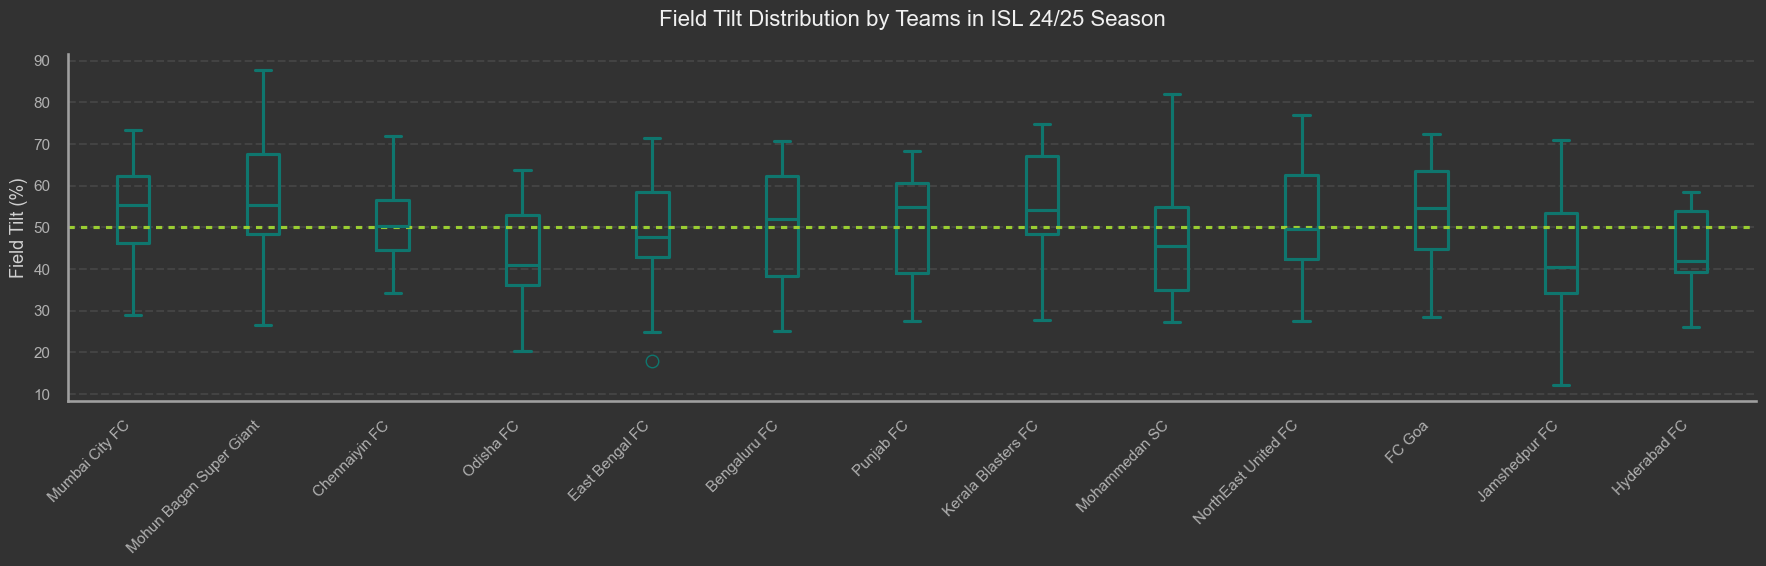

In [46]:


plt.figure()
ax = sns.boxplot(data=dfs['field_tilt'], x="team", y="field_tilt",width=.25,fill=False)
ax.axhline(50, color="yellowgreen", dashes=(2, 2))

plt.xticks(rotation=45, ha="right")
plt.ylabel("Field Tilt (%)")
plt.xlabel("")
plt.title("Field Tilt Distribution by Teams in ISL 24/25 Season",pad=20)

plt.tight_layout()
plt.show()


In [18]:
print(dfs['field_tilt']['team'].unique())

['Mumbai City FC' 'Mohun Bagan Super Giant' 'Chennaiyin FC' 'Odisha FC'
 'East Bengal FC' 'Bengaluru FC' 'Punjab FC' 'Kerala Blasters FC'
 'Mohammedan SC' 'NorthEast United FC' 'FC Goa' 'Jamshedpur FC'
 'Hyderabad FC']
